# Apply Topic Modelling Analysis on COVID-19 Documents with NMF

This jupyter notebook demonstrates document clustering with NMF topic modelling and generating tags from the clustered documents.

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
import nltk
import ast
import datetime as dt
import operator
import re
import pathlib
import timeit
from wordcloud import WordCloud
from collections import Counter
from sklearn.decomposition import NMF
from itertools import combinations
import warnings
import sys
warnings.filterwarnings('ignore')

In [2]:
PATH = '../coronavirus_twenty_years_of_research/technical_validation/'

## Load data

In [3]:
df = pd.read_pickle(PATH + "merged_covid_articles.pkl")
V = pickle.load( open(PATH + "_V_tfidf.pkl", "rb") )
D = pickle.load( open(PATH + "_D_tfidf.pkl", "rb") )

In [102]:
print("Number of research articles for NMF topic modelling: ", len(df))

Number of research articles for NMF topic modelling:  828566


## Apply topic modelling

In [5]:
k = int(sys.argv[1])
NMF_model = NMF(n_components=k, init='nndsvd', random_state=1).fit(D)
H = NMF_model.transform(D) # articles by topic
W = NMF_model.components_  # topics by words.

In [6]:
# identify first and second topic for each article

top_1_cluster_list=[]
top_2_cluster_list=[]

for a in H:
    top_2_idx = np.argsort(a)[-2:]
    top_2_values = [a[i] for i in top_2_idx]
    top_1_cluster_list.append(str(top_2_idx[1]))
    top_2_cluster_list.append(str(top_2_idx[0]))

df['top1_cluster'] = top_1_cluster_list
df['top2_cluster'] = top_2_cluster_list

## Explore topic modelling results

### Topic keywords

In [23]:
def print_topic_keyword(model, n_top_words, V, k):
    feature_names = V.get_feature_names_out()
    keywords_df = pd.DataFrame()
    fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharex=True)
    axes = axes.flatten()
    t = 0
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        keywords_df["Cluster #{} keywords".format(t)] = top_features
        keywords_df["Cluster #{} keywords weights".format(t)] = weights
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        
        t +=1
        
        for p in ax.patches:
            if topic_idx == 0:
                ax.annotate(str(round(p.get_width(),2)), (6.5, p.get_y() + p.get_height()),size=16)
            else:
                ax.annotate(str(round(p.get_width(),2)), (5.5, p.get_y() + p.get_height()),size=16)
    
        ax.set_title(f"Cluster# {topic_idx}", fontdict={"fontsize": 20})
        
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
            
    keywords_df.to_csv(PATH+"figure6_top_{}_keywords_for_clusters.csv".format(n_top_words), sep=',', encoding='utf-8', index=False)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig('../img/Figure6-Top-10-keywords-for-clusters.png', bbox_inches='tight') 
    plt.show()
    return keywords_df

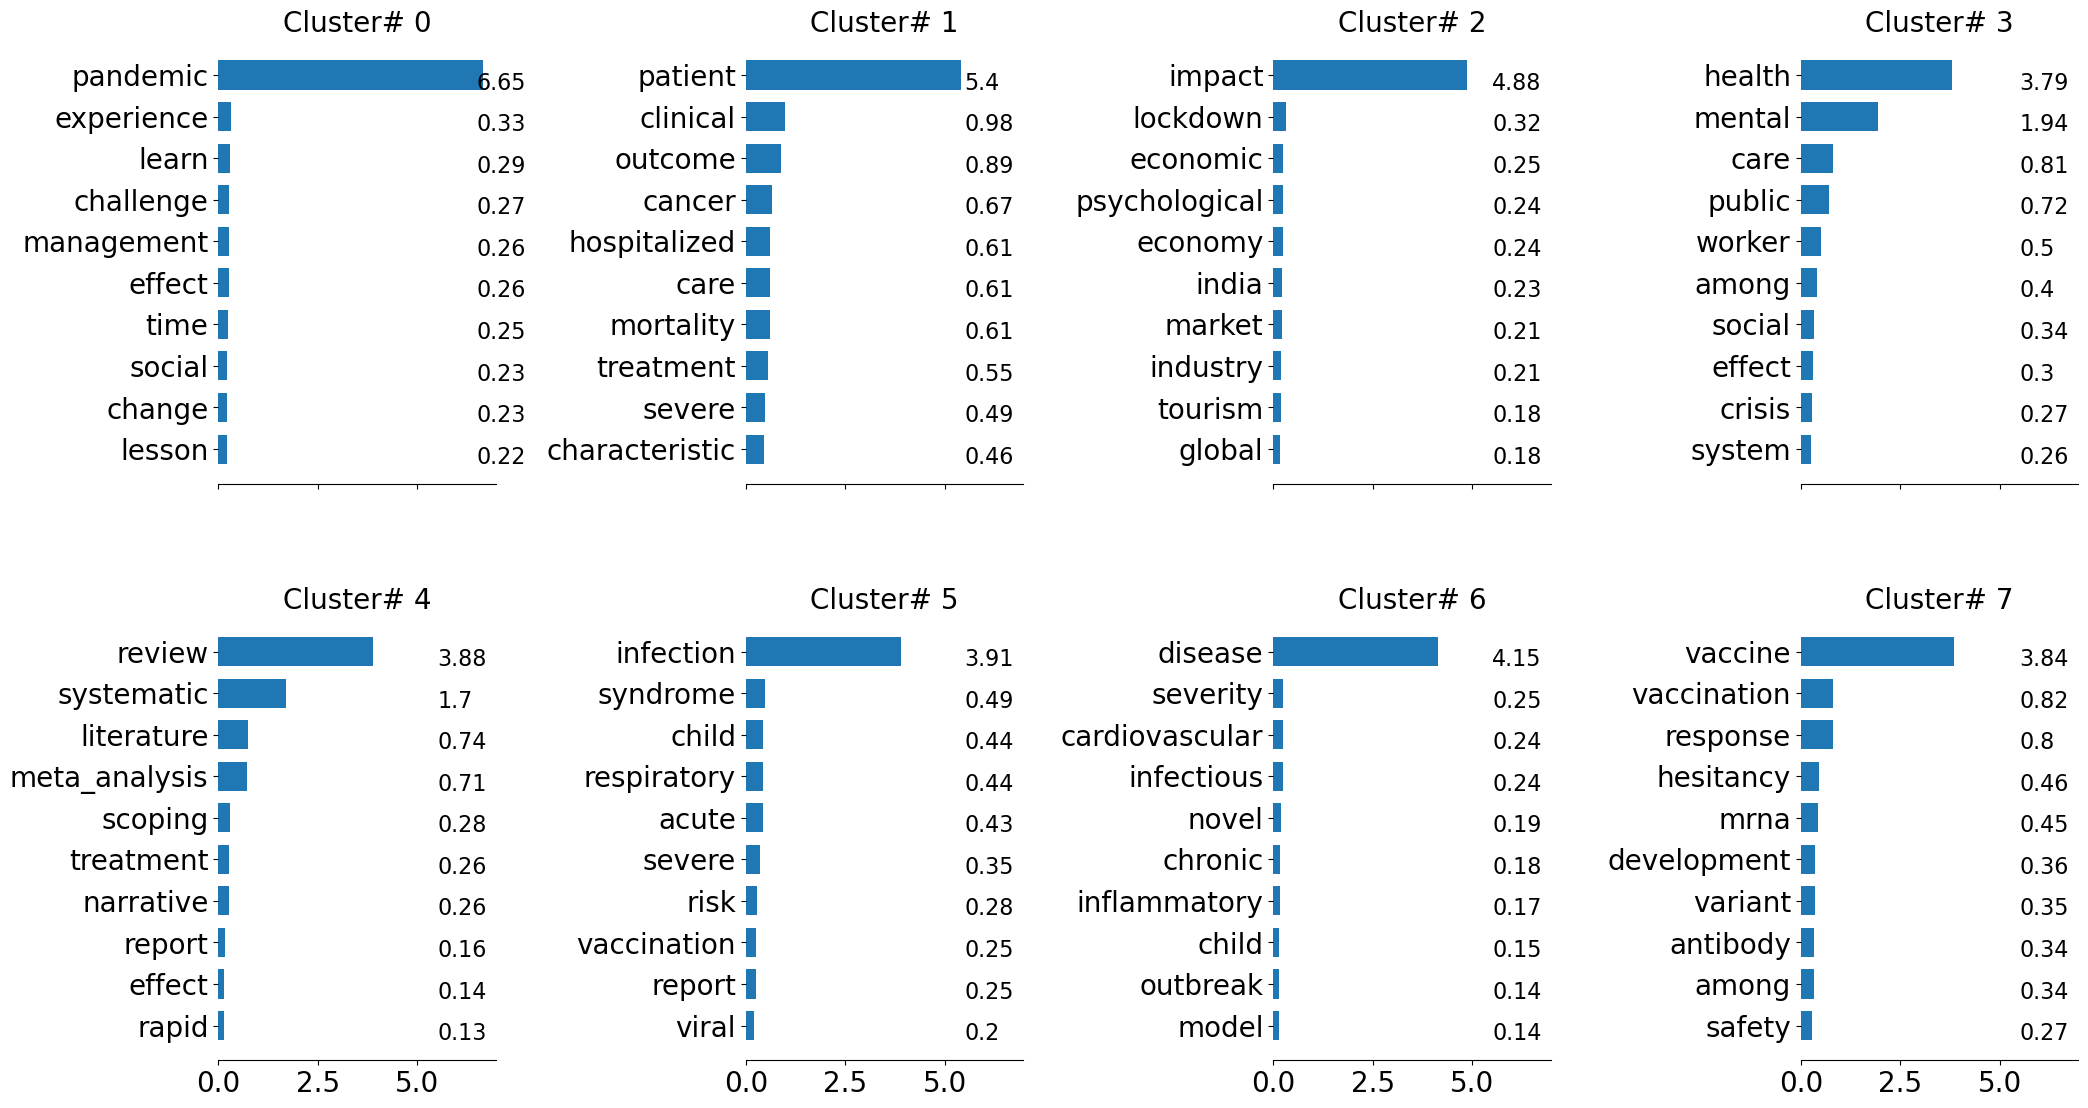

In [24]:
number_of_top_keywords = 10
keywords_df = print_topic_keyword(NMF_model, number_of_top_keywords, V, k)

### Articles by topic

In [71]:
def show_distribution(clusters, num_of_articles):
    plt.figure(figsize=(12, 6))
    plt.bar(clusters, num_of_articles)
    plt.yticks(fontsize=14)
    plt.ylim(0, max(num_of_articles) + 50000)
    plt.ylabel('Number of research articles', fontsize=14)
    plt.xlabel('Clusters', fontsize=14)
    for index, value in enumerate(num_of_articles):
        plt.text(index-0.3, num_of_articles[index]+1000, f"{num_of_articles[index]:,}", fontsize=12)

    plt.savefig('../img/Figure12-Distribution-of-articles-across-clusters.png', bbox_inches='tight')  
    plt.show()

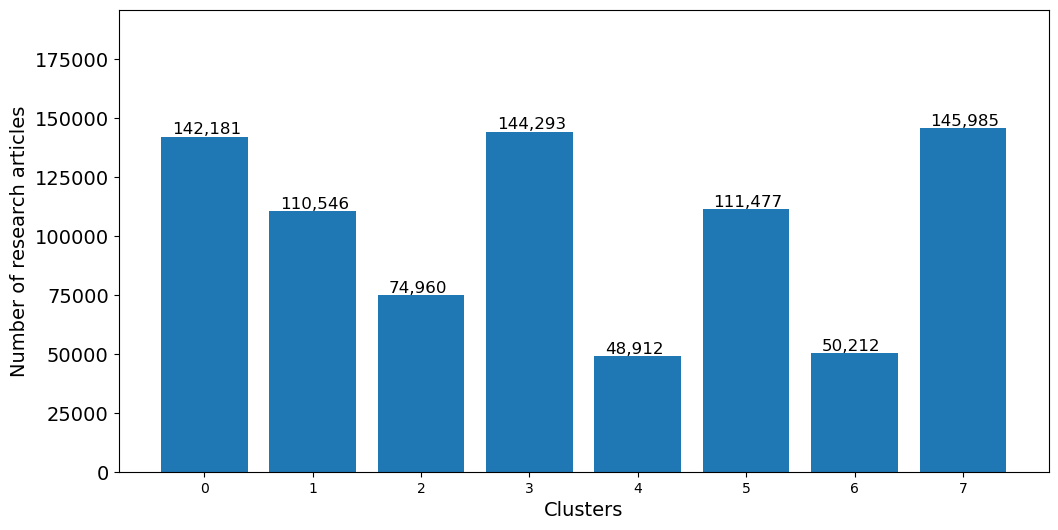

In [72]:
# show number of articles per topic
num_of_articles = []
for cluster in range(k):
    num_of_articles.append(len(df.loc[df['top1_cluster'] == str(cluster)]))
    
show_distribution(range(k), num_of_articles)

article_ditribution_df = pd.DataFrame()
article_ditribution_df['Research cluster'] = range(k) 
article_ditribution_df['Number of articles'] = num_of_articles 
article_ditribution_df.to_csv(PATH+"figure12_distribution_of_articles_across_clusters.csv", sep=',', index=False)

### Article co-occurrence 

In [11]:
c_pair_x_num = {} # coumt number of x
c_pair_x_sum = {} # sum of x
for index, row in df.iterrows():
    c_pair = (row['top1_cluster'], row['top2_cluster'])
    if c_pair not in c_pair_x_num.keys():
        c_pair_x_num[c_pair] = 1
    else:
        c_pair_x_num[c_pair] += 1
        
# number of co-occurrence
co_oc_df = pd.DataFrame(columns=['Cluster1', 'Cluster2', '# articles'])
for i in range(k):
    for j in range(k):
        if i == j:continue
        co_oc_df = co_oc_df._append({
            "Cluster1":str(i),
            "Cluster2":str(j),
            "# articles":str(c_pair_x_num[(str(i), str(j))] + c_pair_x_num[(str(j), str(i))])}, ignore_index=True)
        
# convert DF to matrix format
matrix_df = pd.DataFrame()
for c1 in range(k):
    placeholders = []
    for c2 in range(k):
        placeholders.append(0)
    matrix_df[c1] = placeholders

# co-occurrence rate
for index, row in co_oc_df.iterrows():
    cluster1 = int(row['Cluster1'])
    cluster2 = int(row['Cluster2'])
    cooccurrence = row['# articles']
    num_articles_in_first_collection = len(df.loc[df['top1_cluster'] == str(cluster1)])
    num_articles_in_second_collection = len(df.loc[df['top1_cluster'] == str(cluster2)])
    co_rate = round(int(cooccurrence)/(num_articles_in_first_collection + num_articles_in_second_collection), 2)
    matrix_df[cluster2].iloc[cluster1] = co_rate
matrix_df.to_csv(PATH + "figure10_cooccurrence_matrix.csv", index=False)

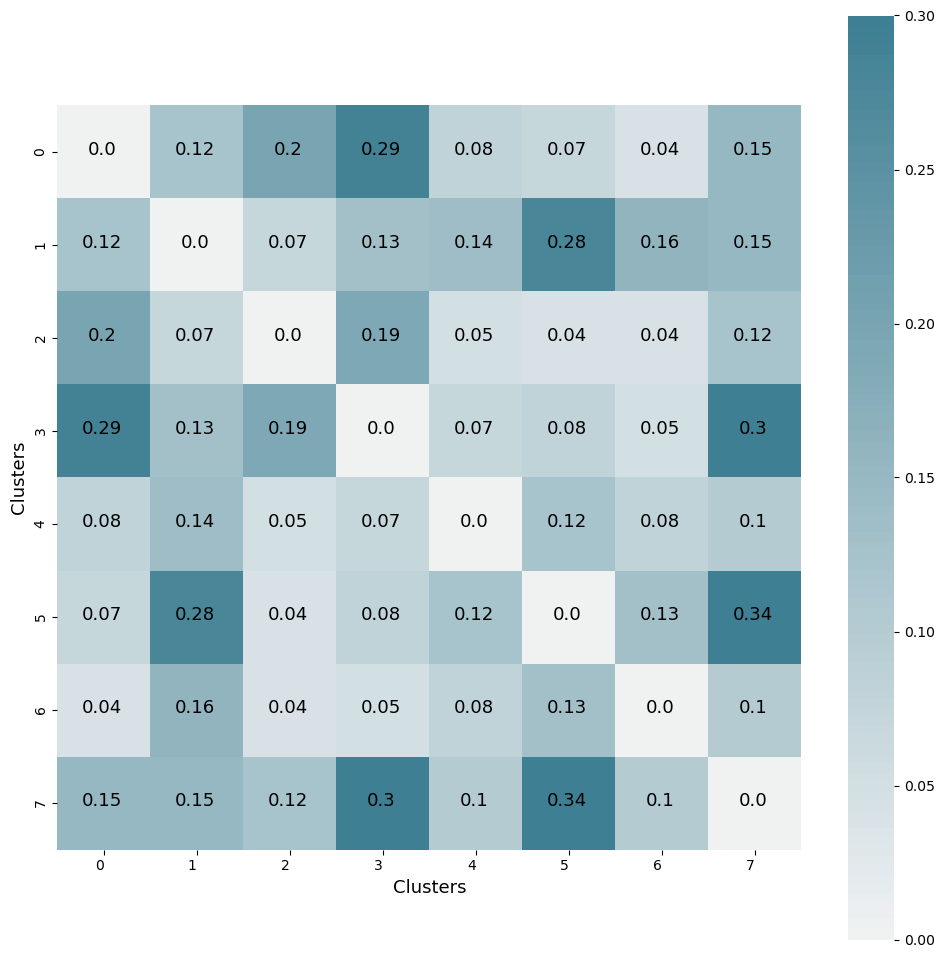

In [14]:

fig, ax = plt.subplots(figsize=(12,12))         
ax = sns.heatmap(
    matrix_df, 
    vmin=0, vmax=0.3, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);
j = k
for c in matrix_df.columns:
    i = 0
    for index, row in matrix_df.iterrows():
        value = row[c]
        ax.text(i/k+0.06, j/k-0.06, round(value, 2), horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes, fontsize=13)
        i += 1
    j -= 1
plt.xlabel('Clusters', fontsize = 13) 
plt.ylabel('Clusters', fontsize = 13) 

plt.savefig('../img/Figure10-Articles-co-occurrence-rate-over-the-clusters.jpeg', dpi=400, bbox_inches='tight')


### Trend of topic over time

In [29]:
def cleaning_date_text(date):
    row_value = ast.literal_eval(date)
    year = row_value['date-parts'][0][0]
    month = row_value['date-parts'][0][1]
    day = 1
    return "{}/{}/{}".format(month, day, year)

In [61]:
# count number of articles by created month
df['created'] = df['created'].astype(str)
df['date'] = df['created'].apply(lambda x: cleaning_date_text(x))
df['date'] = pd.to_datetime(df['date']).dt.to_period('M')
sorted_df = df.sort_values(by=['date'], inplace=False) # sort by date

In [62]:
groupby_df = sorted_df.groupby(['date'])["_id"].count().reset_index(name="count")
groupby_df.date = groupby_df.date.astype(str)
groupby_df.to_csv(PATH + "figure3_article_by_month.csv")

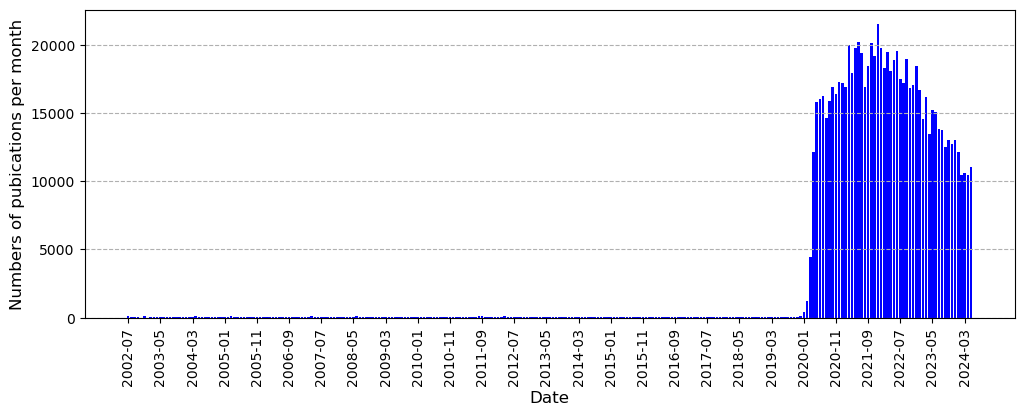

In [75]:
# number of articles per month

months = list(groupby_df['date'])
values = list(groupby_df['count']) 

fig = plt.figure(figsize = (12, 4))
# creating the bar plot
plt.bar(months, values, color='blue')
plt.xticks(np.arange(len(months), step=10), rotation=90) 
plt.xlabel("Date", fontsize=12)
plt.ylabel("Numbers of pubications per month", fontsize=12)
plt.grid(True, axis='y', linestyle='--')

plt.savefig('../img/Figure3-article-by-month1.pdf', format='pdf', bbox_inches='tight') 
plt.show()

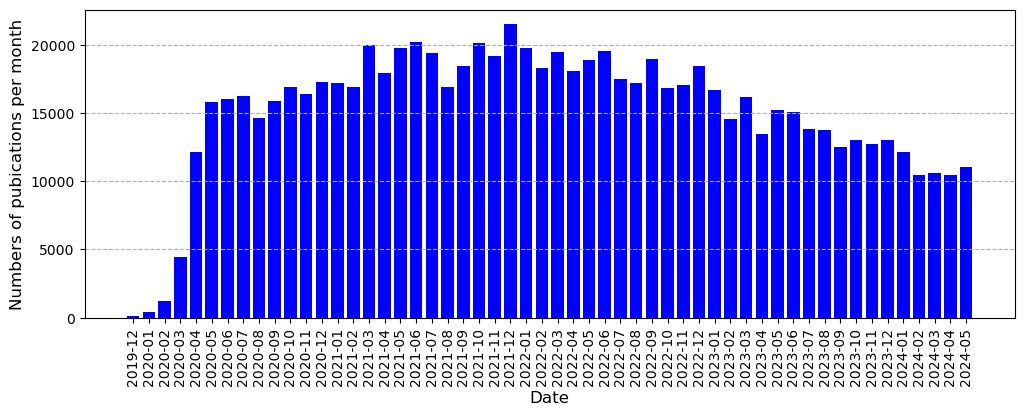

In [76]:
# number of articles per month in the last n months

last_months = 54

months = list(groupby_df['date'].iloc[-last_months:])
values = list(groupby_df['count'].iloc[-last_months:]) 

fig = plt.figure(figsize = (12, 4))
# creating the bar plot
plt.bar(months, values, color='blue')
plt.xticks(rotation=90) 
plt.xlabel("Date", fontsize=12)
plt.ylabel("Numbers of pubications per month", fontsize=12)
plt.grid(True, axis='y', linestyle='--')
plt.savefig('../img/Figure3-article-by-month2.pdf', format='pdf', bbox_inches='tight') 
plt.show()

In [67]:
# count number of article by month and cluster

sorted_df['top1_cluster'] = sorted_df['top1_cluster'].apply(lambda x:'Cluster#' + '{:02d}'.format(int(x)))
cluster_groupby_df = sorted_df.groupby(['date', 'top1_cluster'])["_id"].count().reset_index(name="count")

In [68]:
# convert pivot table, thus each topic become column where value indicate number of document
table = pd.pivot_table(cluster_groupby_df, values='count', index=['date'],
                    columns=['top1_cluster'], aggfunc=np.sum, fill_value=0)

table = table.reindex(sorted(table.columns), axis=1)

In [69]:
# convert table where values are cumulative
cum_table = table.cumsum(axis=0)
cum_table.to_csv(PATH + "figure13_article_trend(num).csv")

In [70]:
# rank cluster
rank_cum_table = pd.DataFrame(columns=list(cum_table.columns))
i = 0
for index, row in cum_table.iterrows():
    l = cum_table.iloc[i]
    result = [sorted(l, reverse=True).index(x)+1 for x in l]
    rank_cum_table.loc[i] = result
    i += 1
    
rank_cum_table.index= cum_table.index
rank_cum_table.to_csv(PATH + "figure13_article_trend(rank).csv")

In [104]:
def bumpchart(df, selected_collections, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    fig = plt.figure(figsize=(9,6))
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    flag = 0
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)
            
        if col not in selected_collections:
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color='grey', alpha=0.1)
            
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color='green', alpha=0.1)
                
                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
        else: # highlight selected values
            if flag != 1: c = 'red'
            else: c='blue'
            left_yaxis.plot(x, y, **line_args, solid_capstyle='round', color=c, label=col)
            left_yaxis.legend(loc='upper right', fontsize=12)
            left_yaxis.set_xlabel("Date")
            left_yaxis.set_ylabel("Rank")
            # Adding scatter plots
            if scatter:
                left_yaxis.scatter(x, y, **scatter_args, color=c)

                #Adding see-through holes
                if holes:
                    bg_color = left_yaxis.get_facecolor()
                    left_yaxis.scatter(x, y, color= bg_color, **hole_args)
            flag = 1
    # Number of lines
    lines = len(df.columns)
    y_ticks = [*range(0, lines)]
    
    x_ticks = []
    for j in range(1, len(df.index)+1, 14):
        x_ticks.append(rank_cum_table.index[j])
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))

    start_date = df.index.min()
    end_date = df.index.max()
    
    left_yaxis.set_xlim(start_date, end_date)
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    axis.xaxis.set_major_locator(plt.MaxNLocator(12))
    
    return axes

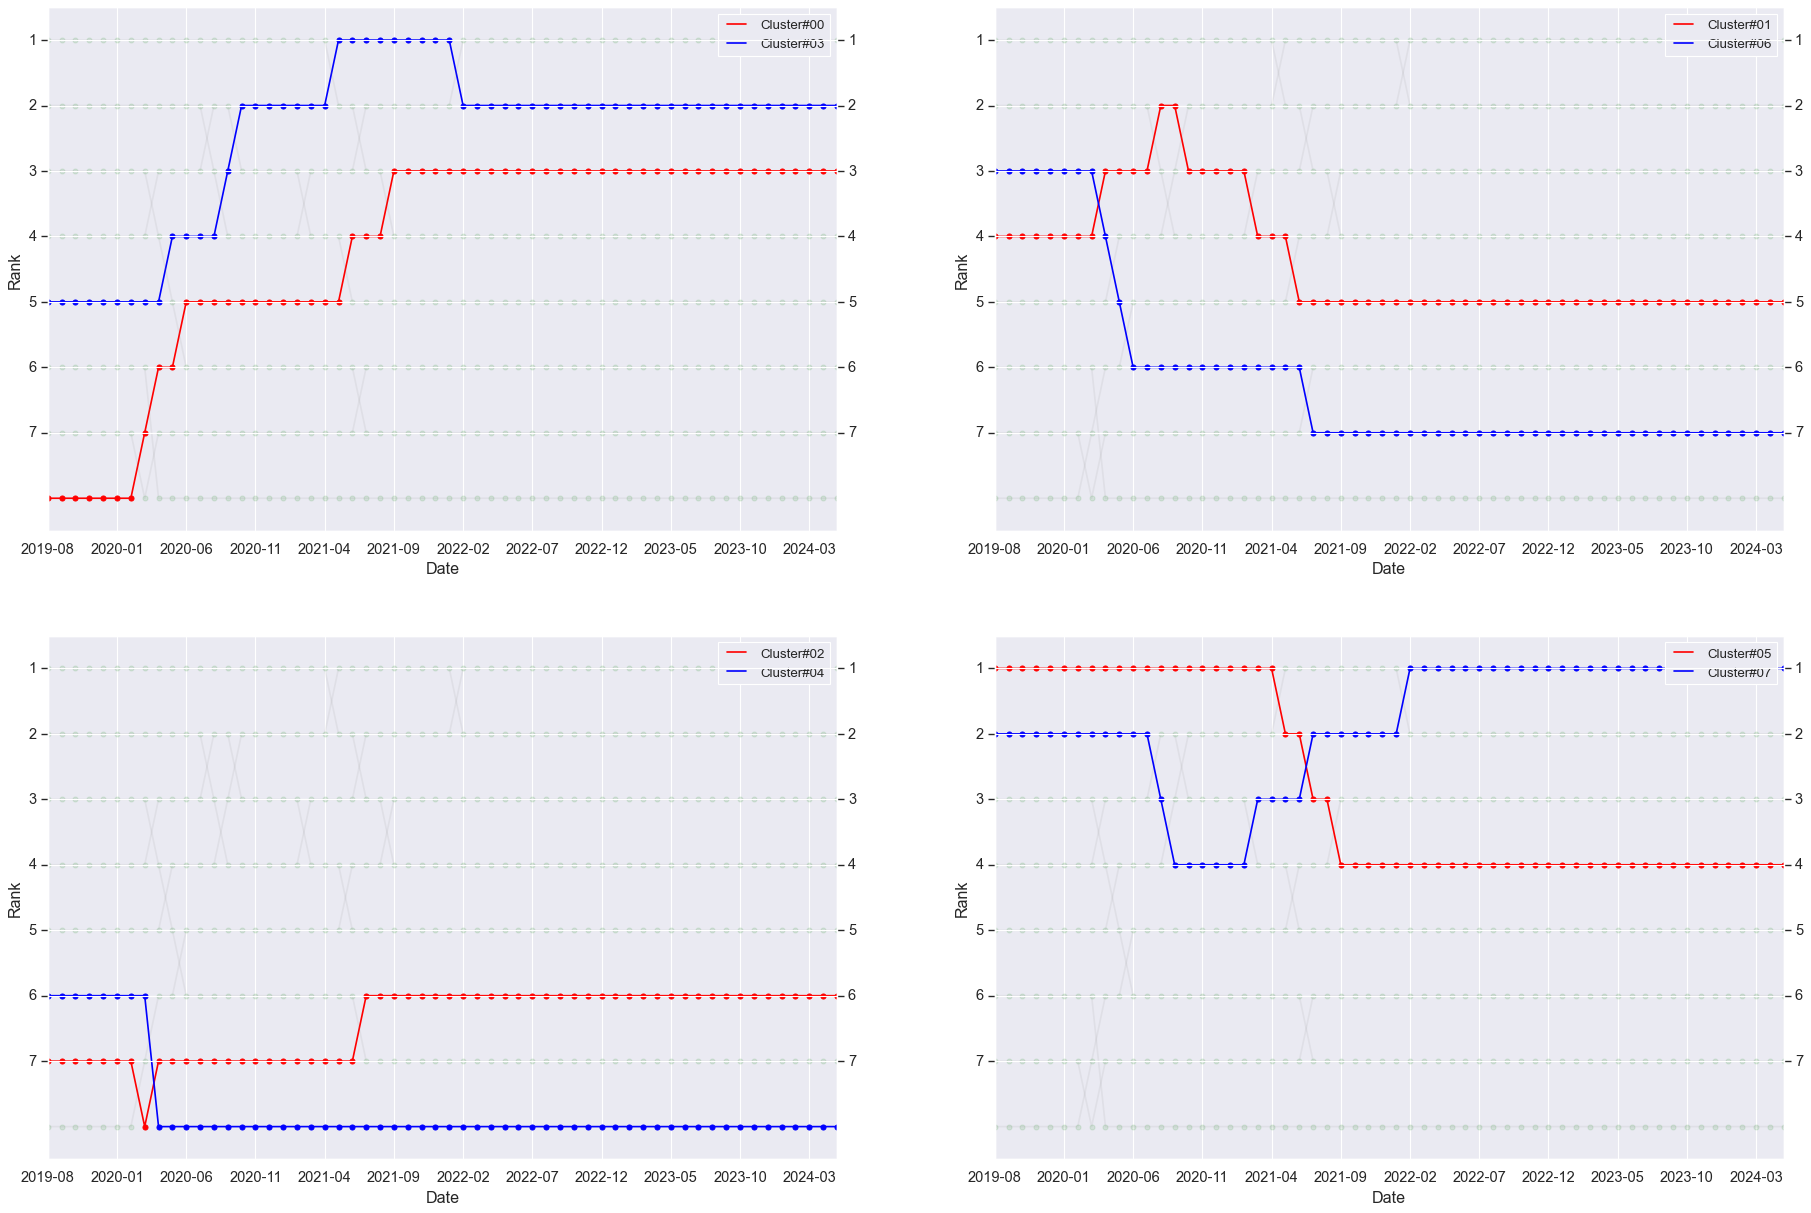

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

<Figure size 720x480 with 0 Axes>

In [106]:
fig, axs = plt.subplots(2,2, figsize=(28,18))

last_month = 58
rank_cum_table.index = rank_cum_table.index.astype(str)

bumpchart(rank_cum_table.tail(last_month), ['Cluster#00', 'Cluster#03'], show_rank_axis= False, scatter=True, ax=axs[0][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#01', 'Cluster#06'], show_rank_axis= False, scatter=True, ax=axs[0][1])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#02', 'Cluster#04'], show_rank_axis= False, scatter=True, ax=axs[1][0])
bumpchart(rank_cum_table.tail(last_month), ['Cluster#05', 'Cluster#07'], show_rank_axis= False, scatter=True, ax=axs[1][1])

fig.savefig("../img/Figure13-Research-topic-trends-vary-over-time.jpeg", dpi=200)
fig.show()

### Wordcloud by topic

We create wordcloud for each cluster based on word frequency of top 1 cluster articles (Exclude articles matched with top2 clusters). 

In [29]:
import random 

font_path = "/Library/Fonts/Arial.ttf"

def getRandomCol():
    r = random.randrange(30, 180)
    g = random.randrange(30, 180)
    b = random.randrange(30, 180)
    return (r, g, b)

def show_wordcloud(df):
    #topics = list(set(df['research_topic']))
    i = 0
    fig = plt.figure(figsize=(18,5))
    for t in range(k):
        ax = fig.add_subplot(2,4,i+1)
        topic_df = df.loc[df['top1_cluster'] == str(t)]
        text = ''
        for index, row in topic_df.iterrows():
            text += row['text']
        wordcloud = WordCloud(background_color="white", collocations=False).generate(str(text))
        plt.title("Cluster {}".format(t))
        colour = getRandomCol()
        ax.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs: colour))
        ax.axis('off')
        i += 1
    plt.tight_layout()
    plt.savefig('../img/Figure7-Word-cloud-for-each-topic-cluster.jpeg', dpi=300, bbox_inches='tight')
    plt.show()

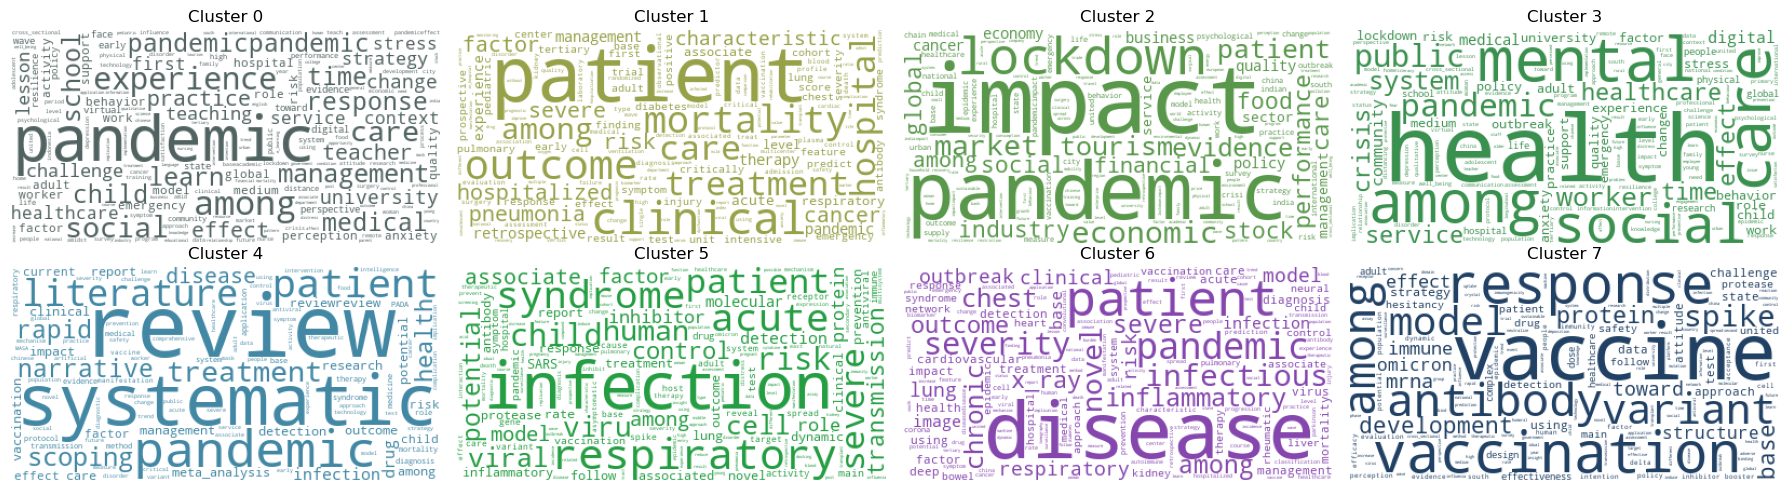

In [30]:
show_wordcloud(df)

In [31]:
def word_counter(topic_text_df, t):
    word_freq_dict = {}
    words_array = []
    counts_array = []

    for row in topic_text_df.text:
        words = row.split()
        for word in words:
            if word in word_freq_dict:
                word_freq_dict[word] += 1
            else:
                word_freq_dict[word] = 1

    sorted_word_freq = dict(sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=True))
    top_words = list(sorted_word_freq.items())[:100]
    for word, count in top_words:
        words_array.append(word)
        counts_array.append(count)
    
    return [words_array, counts_array]

In [32]:
word_freq_df = pd.DataFrame()

for t in range(k):
    topic_df = df.loc[df['top1_cluster'] == str(t)]
    word_counts = word_counter(topic_df, t)
    word_freq_df['cluster_{}_words'.format(t)] = word_counts[0]
    word_freq_df['cluster_{}_words_frequency'.format(t)] = word_counts[1]
word_freq_df.to_csv(PATH + "figure7_word_frequency_for_wordcloud(top100).csv", index=False)

### MetaData

In [80]:
def count_publisher(df):
    missing_article = df['publisher'].isnull().sum()
    percent = round(missing_article/len(df)*100, 1)
    print("Missing publisher: {} ({}%)".format(missing_article, percent))
    publisher_df = df.groupby('publisher')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    publisher_df.columns = ['publisher','Number of publications']
    return publisher_df

In [81]:
def count_container(df):
    df['container-title'] = df['container-title'].astype(str)
    missing_article = len(df.loc[df['container-title'] == 'nan'])
    print("Missing container: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    df = df.loc[df['container-title'] != 'nan']
    container_df = df.groupby('container-title')['_id'].nunique().sort_values(ascending=False).to_frame().reset_index()
    container_df.columns = ['container_title','Number of publications']
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("['", ''))
    container_df['container_title'] = container_df['container_title'].apply(lambda x: x.replace("']", ''))
    return container_df

In [82]:
def count_funder(df):
    df['funder'] = df['funder'].astype(str)
    missing_article = len(df.loc[df['funder'] == 'nan'])
    print("Missing funder: {} ({}%)".format(missing_article, round(missing_article/len(df)*100, 1)))
    df = df.loc[df['funder'] != 'nan']
    funder_dict = {}
    for index, row in df.iterrows():
        if len(str(row['funder'])) > 3:
            funders = eval(row['funder'])
            for f in funders:
                try:
                    funder = f['name']
                    if funder in funder_dict.keys():
                        funder_dict[funder] += 1
                    else:
                        funder_dict[funder] = 1
                except:
                    continue

    sorted_funder_dict = dict( sorted(funder_dict.items(), key=operator.itemgetter(1),reverse=True))
    funder_df = pd.DataFrame()
    funder_df['Funders'] = sorted_funder_dict.keys()
    funder_df['Number of publications'] = sorted_funder_dict.values()
    return funder_df

In [83]:
p_df = count_publisher(df)
c_df = count_container(df)
f_df = count_funder(df)

top_n = 10

p_df.head(top_n).to_csv(PATH + "figure11_top_publishers.csv", index=False)
c_df.head(top_n).to_csv(PATH + "figure11_top_journals.csv", index=False)
f_df.head(top_n).to_csv(PATH + "figure11_top_funder.csv", index=False)

Missing publisher: 35 (0.0%)
Missing container: 100546 (12.1%)
Missing funder: 712142 (85.9%)


In [84]:
def draw_subplots(top_n, df1, df3, df4):
    plt.style.use('classic')
    fig, axs = plt.subplots(3,1,figsize=(10,18))
    
    x_axis_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    x = list(df1['publisher'].iloc[:top_n])
    y = list(df1['Number of publications'].iloc[:top_n])  
    
    x_l = ["(" + x_axis_labels[i] +") - " + x[i] for i in range(0, len(x))]
    axs[0].barh(x_l, y, color='#728FCE')
    axs[0].invert_yaxis() 
    for p in axs[0].patches:
        axs[0].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[0].title.set_text("Top Publishers")
    
    
    
    x = list(df3['container_title'].iloc[:top_n])
    x[1] = "IJERPH"
    y = list(df3['Number of publications'].iloc[:top_n])   
    
    x_l = ["(" + x_axis_labels[i] +") - " + x[i] for i in range(0, len(x))]
    axs[1].barh(x_l, y, color='#728FCE')
    axs[1].invert_yaxis() 
    for p in axs[1].patches:
        axs[1].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[1].title.set_text("Top Journals/conferences")
    
    
    
    x = list(df4['Funders'].iloc[:top_n])
    y = list(df4['Number of publications'].iloc[:top_n])     
    
    x_l = ["(" + x_axis_labels[i] +") - " + x[i] for i in range(0, len(x))]
    axs[2].barh(x_l, y, color='#728FCE')
    axs[2].invert_yaxis() 
    for p in axs[2].patches:
        axs[2].annotate(str(p.get_width()), (p.get_width()+10 , p.get_y() + p.get_height() / 2),fontsize=10)
    axs[2].title.set_text("Top Funders")
    
    plt.savefig('../img/Figure11-The-overview-of-the-publications-metadata.jpeg', dpi=400, bbox_inches='tight')     
    

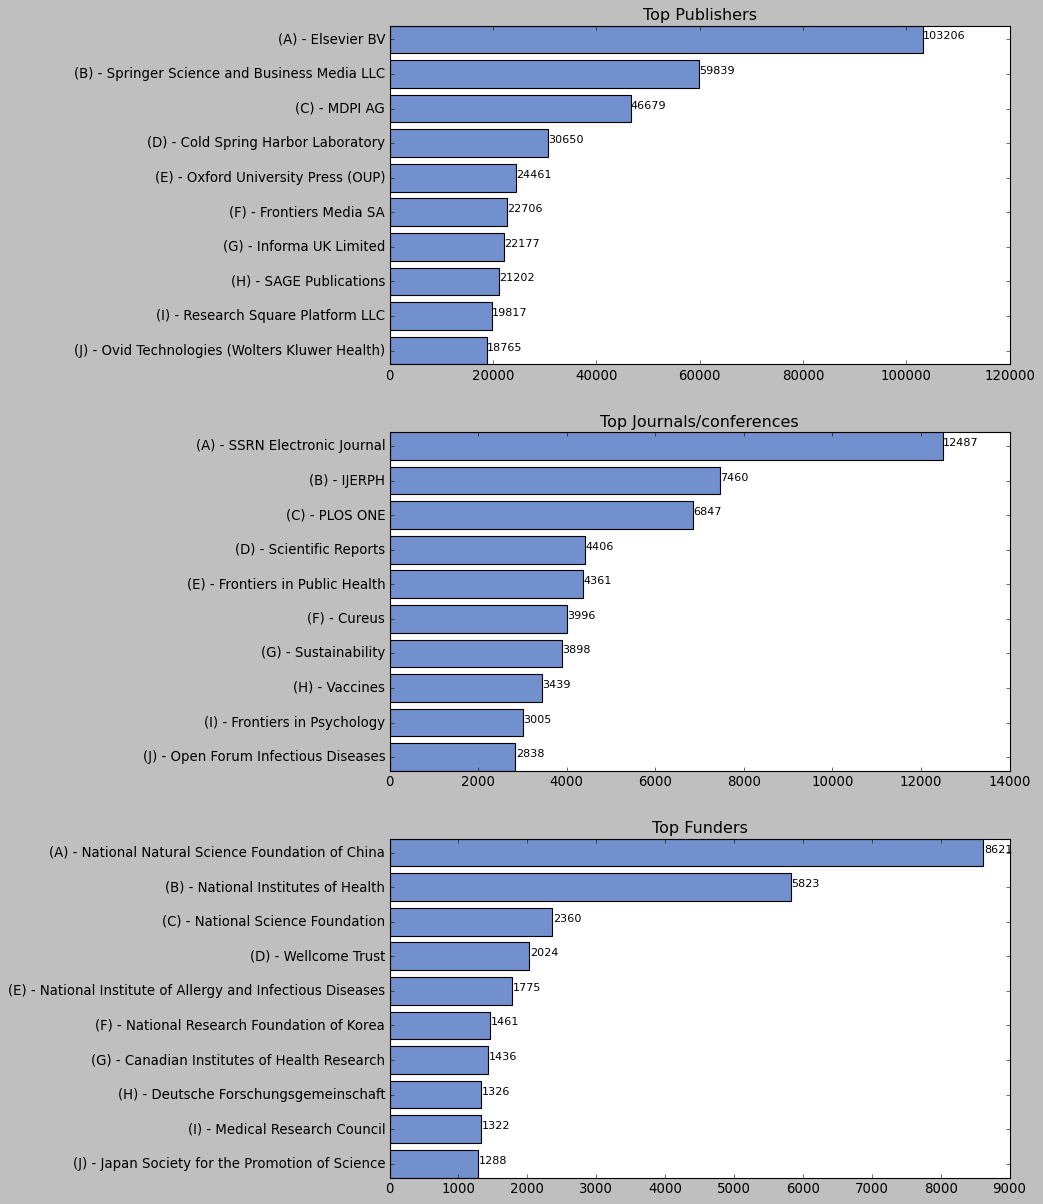

In [85]:
draw_subplots(top_n, p_df, c_df, f_df)

### Metadata dependency matrix

In [86]:
top_n = 10

In [87]:
def draw_heatmap(df, metadata, ylabel):

    conf_matrix_df = df.set_index(metadata)
    
    fig, ax = plt.subplots(figsize=(10,4))    
    x_axis_labels = [0, 1, 2, 3, 4, 5, 6, 7]
    y_axis_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    sns.heatmap(conf_matrix_df, 
                vmin=0, 
                vmax=conf_matrix_df.max(axis=1)[0], 
                center=1,
                cmap=sns.diverging_palette(20, 220, n=200),
                #square=True,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels,
                fmt=".1f" )
    j = k
    for index, row in conf_matrix_df.iterrows():
        i = 0
        for c in conf_matrix_df.columns:
            value = row[c]
            ax.text(i/k+0.06, j/(k+2.1)+0.15, round(value, 2), horizontalalignment='center',
                 verticalalignment='center', transform=ax.transAxes)
            i += 1
        j -= 1
    sns.set(font_scale=1.2)
    plt.xlabel('Clusters')
    plt.ylabel(ylabel, labelpad=20)
    plt.savefig('../img/Figure11-{}-by-cluster.png'.format(metadata), dpi=800, bbox_inches='tight') 
    plt.show()

#### Publisher

In [88]:
metadata = 'publisher'

# get top n publishers
publishers_df = count_publisher(df)
top_publishers = publishers_df.publisher[:top_n]
top_publishers = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_publishers))

# create dependency matrix to save the percentage of articles with the publisher
publisher_df = pd.DataFrame()
publisher_df['publishers'] = top_publishers

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata].notnull()]
    for w in top_publishers:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    publisher_df['cluster#{}'.format(str(i))] = tmp_list
publisher_df.to_csv(PATH + "figure11_publisher-by-clusters.csv", index=False)

Missing publisher: 35 (0.0%)


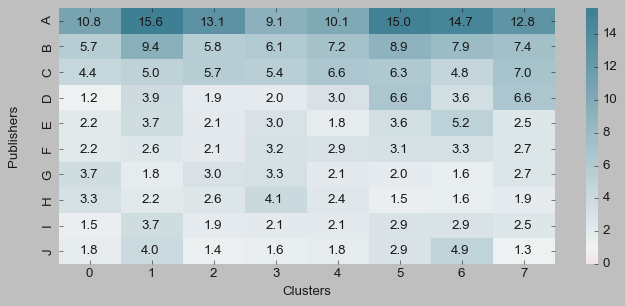

In [89]:
draw_heatmap(publisher_df, 'publishers', 'Publishers')

#### Journal

In [90]:
metadata = 'container-title'
journal_df = count_container(df)
top_journals = journal_df['container_title'][:top_n]
top_journals = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_journals))

Missing container: 100546 (12.1%)


In [91]:
# create dependency matrix to save the percentage of articles with the journal
# code modified as string contain capture irrelevant journal

journal_df = pd.DataFrame()
journal_df[metadata] = top_journals

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_journals:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata] == "['{}']".format(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    journal_df['cluster#{}'.format(str(i))] = tmp_list
journal_df.to_csv(PATH + "figure11_journal-by-clusters.csv", index=False)

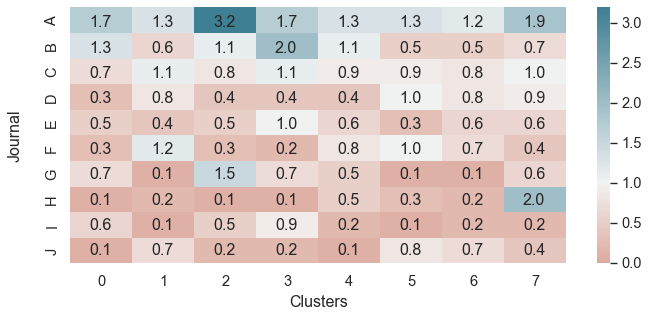

In [92]:
draw_heatmap(journal_df, 'container-title', 'Journal')

#### Funder

In [93]:
metadata = 'funder'
funder_df = count_funder(df)
top_funder = funder_df['Funders'][:top_n]
top_funder = list(map(lambda x: re.sub("\(.*?\)|\[.*?\]","",x), top_funder))

Missing funder: 712142 (85.9%)


In [94]:
# create dependency matrix to save the percentage of articles with the funder

funder_df = pd.DataFrame()
funder_df[metadata] = top_funder

for i in range(k):
    tmp_list = []
    tmp_df = df.loc[df['top1_cluster'] == str(i)]
    tmp_with_metadata_df = tmp_df.loc[tmp_df[metadata] != 'nan']
    for w in top_funder:
        num_of_articles_with_metadata = len(tmp_with_metadata_df.loc[tmp_with_metadata_df[metadata].str.contains(w)])
        tmp_list.append(round(num_of_articles_with_metadata/len(tmp_with_metadata_df)*100, 1))
    funder_df['cluster#{}'.format(str(i))] = tmp_list
funder_df.to_csv(PATH + "figure11_funder-by-clusters.csv", index=False)

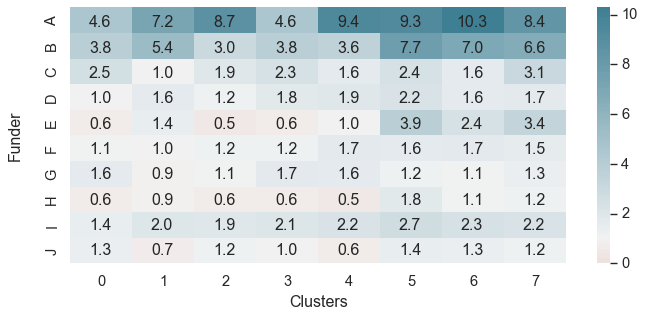

In [95]:
draw_heatmap(funder_df, 'funder', 'Funder')

## Save the result

In [97]:
max_topic_num_list = []
topic_weights_list = []
for weights in H:
    top_idx = np.argsort(weights)[-1:]
    max_topic_num_list.append(top_idx[0])
    weight_dictionary = {}
    for i in range(len(weights)):
        weight_dictionary[i] = round(weights[i], 5)
    topic_weights_list.append(weight_dictionary) # save topic weights

# create new columns and save the results
df['cluster'] = max_topic_num_list
df['cluster-coefficient'] = topic_weights_list

In [98]:
df.drop(columns=['_id', 'top1_cluster', 'top2_cluster', 'text', 'date'], inplace=True)

In [99]:
df.to_csv(PATH + "NMF_topic_modelling_results({}clusters).csv".format(k), index=False)